In [1]:
import json
import os
from math import comb
import csv
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import time

%matplotlib inline
pd.options.display.min_rows = 25

# Add More Fine-Grained Attributes 

## Importing Question Details

In [607]:
questions_detailed = pd.read_csv("Frameset_Questions_Detailed_all.csv")
questions_detailed = questions_detailed[~(questions_detailed['n_choices']==0)] #Because some of them has no choice, it's just "True"
questions_detailed  = questions_detailed.drop_duplicates(subset=['frameset_name', 'question_name'])
questions_detailed['frameset-qID'] = questions_detailed['frameset_name'] + '-'+ questions_detailed.question_id.astype(str)

question_detailed_types = dict(zip(questions_detailed['frameset-qID'], questions_detailed_multi.question_type))

In [608]:
# Dictionary for returning if a the n_choices using key "Frameset-qID"

# Some Multi Choose Questions has only two choices, we will ignore them in our analysis
questions_detailed_multi = questions_detailed[questions_detailed['question_type']=='Multi-Choice'][questions_detailed['n_choices']>1]    
questions_detailed_multi_dict = dict(zip(questions_detailed_multi['frameset-qID'], questions_detailed_multi.n_choices))

questions_detailed_single = questions_detailed[questions_detailed['question_type']=='Single-Choice'][questions_detailed['n_choices']>1]    
questions_detailed_single_dict = dict(zip(questions_detailed_single['frameset-qID'], questions_detailed_single.n_choices))

questions_detailed_TF = questions_detailed[questions_detailed['question_type']=='T/F']  
questions_detailed_TF_dict = dict(zip(questions_detailed_TF['frameset-qID'], questions_detailed_TF.n_choices))

C:\Users\Yusuf\AppData\Local\Temp\ipykernel_27000\1963821710.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  questions_detailed_multi = questions_detailed[questions_detailed['question_type']=='Multi-Choice'][questions_detailed['n_choices']>1]
C:\Users\Yusuf\AppData\Local\Temp\ipykernel_27000\1963821710.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  questions_detailed_single = questions_detailed[questions_detailed['question_type']=='Single-Choice'][questions_detailed['n_choices']>1]


In [609]:
questions_max = questions_detailed.pivot_table(columns='frameset_name', aggfunc=len,values='n_choices').T.reset_index()
multi_questions_max = questions_max[questions_max.frameset_name.isin(questions_detailed_multi.frameset_name.unique())]

## Importing Session Interactions

In [610]:
sessions_interactions_20_21 = pd.read_excel('../Sessions_1D_old_names.xlsx')
sessions_interactions_22 = pd.read_excel('../Spring_22/Sessions_1D_22.xlsx')

In [611]:
sessions_interactions_20_21['frameset-qID'] = sessions_interactions_20_21['curr_frameset_name'] + '-'+ sessions_interactions_20_21.question_id.astype(str)
sessions_interactions_22['frameset-qID'] = sessions_interactions_22['curr_frameset_name'] + '-'+ sessions_interactions_22.question_id.astype(str)

In [612]:
sessions_interactions_20_21['session_number'] +='-20_21'

# sessions_interactions_20_21 = sessions_interactions_20_21[sessions_interactions_20_21['frameset-qID'].isin(questions_detailed_multi['frameset-qID'].unique())]

In [613]:
sessions_interactions_22['session_number'] +='-22'

In [614]:
sessions_interactions_all = pd.concat([sessions_interactions_20_21, sessions_interactions_22 ])
sessions_interactions_all = sessions_interactions_all[sessions_interactions_all.curr_frameset_name.isin(questions_detailed.frameset_name)]

## Importing Session CLusters

In [615]:
clustered_sessions_20_21 = pd.read_csv("../Clustered_Sessions_FCM.csv")
clustered_sessions_20_21['session_number'] +='-20_21'

clustered_sessions_22 = pd.read_csv("../Spring_22/Clustered_Sessions_FCM.csv")
clustered_sessions_22['session_number'] +='-22'

clustered_sessions_all = pd.concat([clustered_sessions_20_21,clustered_sessions_22])
clustered_sessions_all.columns # Use it to get if a session is credit seeking or normal

Index(['Unnamed: 0', 'cluster', 'user_id', 'session_number',
       'curr_frameset_name', 'Percentage_incorrects', 'Percentage_corrects',
       'percent_consecutive_incorrect_interactions',
       'percent_consecutive_correct_interactions', 'n_backs',
       'nth_trial_of_frame', 'time_between_median', 'u'],
      dtype='object')

In [616]:
multi_framesetnames = questions_detailed_multi.frameset_name .unique()

multi_sessions = clustered_sessions_all[clustered_sessions_all.curr_frameset_name.isin(multi_framesetnames)]

len(clustered_sessions_all), len(multi_sessions), len(multi_sessions[multi_sessions.cluster =="Credit Seeking"]), len(multi_sessions[multi_sessions.cluster =="Normal"])

(12689, 10891, 4157, 6734)

In [602]:
multi_framesetnames = questions_detailed_multi.frameset_name .unique()

multi_sessions = clustered_sessions_all[clustered_sessions_all.curr_frameset_name.isin(multi_framesetnames)]

len(clustered_sessions_all), len(multi_sessions), len(multi_sessions[multi_sessions.cluster =="Credit Seeking"]), len(multi_sessions[multi_sessions.cluster =="Normal"])

(12689, 10865, 4148, 6717)

In [454]:
clusters_attributes = [
    "Percentage_incorrects",
    "Percentage_corrects",
    "percent_consecutive_incorrect_interactions", 
    'percent_consecutive_correct_interactions',
    "time_spent_incorrect_multi",
    "n_incorrect_attempts_multi",
    "n_correct_attempts_multi",  
    'questions_incorrect_multi', # []
    "questions_correct_multi", # [] , Probably will contain incorrects to 
    "choices_multi",  
    "solutions_multi" ,  
    'n_interactions',
    'time_spent_multi' 
]

In [134]:
def get_n_two_conseuctive_incorrect(activities):
    cnt = 0
    flag = False
    for activity in activities:
        if activity == "X" and flag == False:
            flag = True
        elif activity == "X" and flag == True:
            cnt += 1
        elif activity != "X":
            flag = False
    return cnt

def get_n_two_conseuctive_correct(activities):
    cnt = 0
    flag = False
    for activity in activities:
        if activity == "Crrct" and flag == False:
            flag = True
        elif activity == "Crrct" and flag == True:
            cnt += 1
        elif activity != "Crrct":
            flag = False
    return cnt

def get_n_incorrect(activities):
    cnt = 0
    for activity in activities:
        if activity == "X" :
            cnt+=1
    return cnt


def get_n_correct(activities):
    cnt = 0
    for activity in activities:
        if activity == "Crrct" :
            cnt+=1
    return cnt

In [185]:
len(clusters_attributes)

13

In [543]:
sessions_interactions_all

,Unnamed: 0,user_id,session_number,curr_frameset_name,activity_name,question_id,timestamp,frameset-qID
0,0,812,sesssion 1-20_21,MinimizationWithQuestionsFF,Crrct,0,2020-10-11 00:11:18.000,MinimizationWithQuestionsFF-0
1,1,812,sesssion 1-20_21,MinimizationWithQuestionsFF,SESSION_END,0,2020-10-11 00:11:18.001,MinimizationWithQuestionsFF-0
2,2,812,sesssion 2-20_21,LanguagesFS,X,0,2021-01-22 01:37:46.000,LanguagesFS-0
3,3,812,sesssion 2-20_21,LanguagesFS,Crrct,0,2021-01-22 01:37:50.000,LanguagesFS-0
4,4,812,sesssion 2-20_21,LanguagesFS,Crrct,1,2021-01-22 01:38:16.000,LanguagesFS-1
5,5,812,sesssion 2-20_21,LanguagesFS,Crrct,2,2021-01-22 01:38:25.000,LanguagesFS-2
6,6,812,sesssion 2-20_21,LanguagesFS,Crrct,3,2021-01-22 01:39:53.000,LanguagesFS-3
7,7,812,sesssion 2-20_21,LanguagesFS,Crrct,4,2021-01-22 01:40:01.000,LanguagesFS-4
8,8,812,sesssion 2-20_21,LanguagesFS,Crrct,5,2021-01-22 01:40:29.000,LanguagesFS-5
9,9,812,sesssion 2-20_21,LanguagesFS,X,6,2021-01-22 01:40:38.000,LanguagesFS-6


In [ ]:
# The old copy (working), Not Touched
# ['Percentage_incorrects',
#  'Percentage_corrects',
#  'percent_consecutive_incorrect_interactions',
#  'percent_consecutive_correct_interactions',
#  'time_spent_incorrect_multi',
#  'n_incorrect_attempts_multi',
#  'n_correct_attempts_multi',
#  'questions_incorrect_multi',
#  'questions_correct_multi',
#  'choices_multi',
#  'solutions_multi',
#  'n_interactions',
#  'time_spent_multi']
one_row = []
sessions_attributes = []
sessions_attributes_with_user_frameset = []
activity_counter = 0
times_taken_for_incorrect_attempt = []
session_activities = []
time_spent_incorrect_multi = [] ; time_spent_multi = []
n_incorrect_attempts_multi = 0 ; n_correct_attempts_multi = 0 ; n_consecutive_incorrects_multi = 0 
questions_incorrect_multi = set() ; questions_correct_multi =set()
choices_multi = [] ; solutions_multi =[]; 
n_interactions = 0 # Includes multi and non-multi, for multi only sum what we have in n_incorrect and n_correct attempts

nextt = None

for idx in range(1,len(sessions_interactions_all)):
    
    interaction = sessions_interactions_all.iloc[idx]
    if idx != len(sessions_interactions_all) - 1:
        next_interaction =  sessions_interactions_all.iloc[idx+1]
        
    activity = interaction['activity_name']
    question_id = interaction['question_id']
    frameset_name = interaction['curr_frameset_name']
    # If the interaction is SESSION_END then add the prev_session number, and move to the next iteration
    if next_interaction.session_number != interaction.session_number and activity_counter > 2:
        # Here we have been adding all interactions of one session to the list activities
        n_consecutive_incorrects = get_n_two_conseuctive_incorrect(session_activities)
        n_consecutive_corrects =   get_n_two_conseuctive_correct(session_activities)
        n_incorrects = get_n_incorrect(session_activities) #becuase some sessions such as {Crrct --> X --> Crrt --> END_SESSION} will has zero value which doesn't represnt anything about the session
        n_corrects = get_n_correct(session_activities)
        percent_consecutive_incorrect_interactions = n_consecutive_incorrects/len(session_activities)
        percent_consecutive_correct_interactions  = n_consecutive_corrects/len(session_activities)
        
        
        one_row = [n_incorrects/len(session_activities), n_corrects/len(session_activities), round(percent_consecutive_incorrect_interactions,3), round(percent_consecutive_correct_interactions,3), 
                   time_spent_incorrect_multi, n_incorrect_attempts_multi, n_correct_attempts_multi, questions_incorrect_multi, questions_correct_multi, 
                   choices_multi, solutions_multi, activity_counter,time_spent_multi ]
        sessions_attributes.append( one_row )  # Note the current event is a new session, so when you add to attributes, only access the prev iteration values
        sessions_attributes_with_user_frameset.append([interaction['user_id'], interaction['session_number'], interaction['curr_frameset_name']]+ one_row)  # Adding more info to the row
     
    if activity == 'SESSION_END': # Regardless of the activity_counter
        activity_counter = 0
        session_activities = []
        time_spent_incorrect_multi = [];  time_spent_multi = []
        n_incorrect_attempts_multi = 0 ; n_correct_attempts_multi = 0 ; n_consecutive_incorrects_multi = 0 
        questions_incorrect_multi = set() ; questions_correct_multi =set()
        choices_multi = [] ; solutions_multi =[]; 
        n_interactions = 0
        continue # Move directly to the next iteration
    
    session_activities.append(activity)
    activity_counter += 1
    
    
    if interaction['frameset-qID'] in questions_detailed_multi_dict:
        if activity_counter!=1 and activity =='X':
            time_spent_incorrect_multi.append((interaction['timestamp'] - prev['timestamp']).total_seconds())
        if activity_counter!=1 :
            time_spent_multi.append((interaction['timestamp'] - prev['timestamp']).total_seconds())
        if interaction['question_id'] not in questions_correct_multi and interaction['question_id'] not in questions_incorrect_multi:
            choices_multi.append(questions_detailed_multi_dict[interaction['frameset-qID']])
            solutions_multi.append((2**questions_detailed_multi_dict[interaction['frameset-qID']])-1) 
        if activity =='X':
            n_incorrect_attempts_multi+=1;
            questions_incorrect_multi.add(interaction['question_id'])
        if activity =='Crrct':
            n_correct_attempts_multi+=1;
            questions_correct_multi.add(interaction['question_id'])

    prev = interaction


In [545]:
def find_median(listt):
    listt = sorted(listt)
    return listt[round(len(listt)/2)], round(len(listt)/2)

def select_question_and_nchoices(session_number):
    session_interactions = sessions_interactions_all[sessions_interactions_all.session_number == session_number]
    n_session_interactions = len(session_interactions)
    n_choices = []
    questions_ids = session_interactions['question_id'].unique()
    frameset_qIDs = session_interactions['frameset-qID'].unique()
    multi_question_IDs = []
    for qid, frameset_qid in zip(questions_ids,frameset_qIDs):
        if frameset_qid in questions_detailed_multi_dict:
            n_choices.append(questions_detailed_multi_dict[frameset_qid])
            multi_question_IDs.append(qid)
    median, idx = find_median(n_choices)
    return  median, multi_question_IDs[idx]
    # return n_choices, multi_question_IDs, median, multi_question_IDs[idx]

In [550]:
sessions_interactions_all.columns

Index(['Unnamed: 0', 'user_id', 'session_number', 'curr_frameset_name',
       'activity_name', 'question_id', 'timestamp', 'frameset-qID'],
      dtype='object')

In [ ]:
session_numbers = sessions_interactions_all['session_number'].unique()

for session_number in session_numbers:
    n_choices, question_id = select_question_and_nchoices(session_number)
    session_interactions = sessions_interactions_all[session_name][sessions_interactions_all.question_id == question_id]sessions_interactions_all.session_number == 
    n_session_interactions = len(session_interactions)
    n_incorrect =  0
    
    
    for idx, session_interaction in session_interactions.iterrows():
        

In [ ]:
sessions_attributes = []
sessions_attributes_with_user_frameset = []
activity_counter = 0
times_taken_for_incorrect_attempt = []
session_activities = []
time_spent_incorrect_multi = [] ; time_spent_multi = []
n_incorrect_attempts_multi = 0 ; n_correct_attempts_multi = 0 ; n_consecutive_incorrects_multi = 0 
questions_incorrect_multi = set() ; questions_correct_multi =set()
choices_multi = [] ; solutions_multi =[]; 
n_interactions = 0 # Includes multi and non-multi, for multi only sum what we have in n_incorrect and n_correct attempts
session_numbers = session_interactions['question_id'].unique()
nextt = None

# for session_name in session_names:
for idx in range(1,len(sessions_interactions_all)):
    
    interaction = sessions_interactions_all.iloc[idx]
    if idx != len(sessions_interactions_all) - 1:
        next_interaction =  sessions_interactions_all.iloc[idx+1]
    
    number_of_choices = 4
    
    activity = interaction['activity_name']
    question_id = interaction['question_id']
    frameset_name = interaction['curr_frameset_name']
    # If the interaction is SESSION_END then add the prev_session number, and move to the next iteration
    if next_interaction.session_number != interaction.session_number and activity_counter > 2:
        # Here we have been adding all interactions of one session to the list activities
        n_consecutive_incorrects = get_n_two_conseuctive_incorrect(session_activities)
        n_consecutive_corrects =   get_n_two_conseuctive_correct(session_activities)
        n_incorrects = get_n_incorrect(session_activities) 
        n_corrects = get_n_correct(session_activities)
        percent_consecutive_incorrect_interactions = n_consecutive_incorrects/len(session_activities)
        percent_consecutive_correct_interactions  = n_consecutive_corrects/len(session_activities)
        if choices_multi!= []:
            choice_number = find_median(choices_multi)
            question_number = np.where(np.array(choices_multi) == choice_number)[0][0] 
        
        one_row = [n_incorrects/len(session_activities), n_corrects/len(session_activities), round(percent_consecutive_incorrect_interactions,3), round(percent_consecutive_correct_interactions,3), 
                   time_spent_incorrect_multi, n_incorrect_attempts_multi, n_correct_attempts_multi, questions_incorrect_multi, questions_correct_multi, 
                   choices_multi, solutions_multi, activity_counter,time_spent_multi ]
        sessions_attributes.append( one_row )  # Note the current event is a new session, so when you add to attributes, only access the prev iteration values
        sessions_attributes_with_user_frameset.append([interaction['user_id'], interaction['session_number'], interaction['curr_frameset_name']]+ one_row)  # Adding more info to the row
     
    if activity == 'SESSION_END':  
        activity_counter = 0
        session_activities = []
        time_spent_incorrect_multi = [];  time_spent_multi = []
        n_incorrect_attempts_multi = 0 ; n_correct_attempts_multi = 0 ; n_consecutive_incorrects_multi = 0 
        questions_incorrect_multi = set() ; questions_correct_multi =set()
        choices_multi = [] ; solutions_multi =[]; 
        n_interactions = 0
        continue # Move directly to the next iteration
    
    session_activities.append(activity)
    activity_counter += 1
    
    
    if interaction['frameset-qID'] in questions_detailed_multi_dict:
        if activity_counter!=1 and activity =='X':
            time_spent_incorrect_multi.append((interaction['timestamp'] - prev['timestamp']).total_seconds())
        if activity_counter!=1 :
            time_spent_multi.append((interaction['timestamp'] - prev['timestamp']).total_seconds())
        if interaction['question_id'] not in questions_correct_multi and interaction['question_id'] not in questions_incorrect_multi:
            choices_multi.append(questions_detailed_multi_dict[interaction['frameset-qID']])
            solutions_multi.append((2**questions_detailed_multi_dict[interaction['frameset-qID']])-1) 
        if activity =='X':
            n_incorrect_attempts_multi+=1;
            questions_incorrect_multi.add(interaction['question_id'])
        if activity =='Crrct':
            n_correct_attempts_multi+=1;
            questions_correct_multi.add(interaction['question_id'])
        
    prev = interaction


[4, 4, 3, 3, 6, 4, 6, 8, 4] 4 0
[5, 5, 7] 7 2
[2, 2, 4, 4, 2, 2, 3, 3, 4] 3 6
[5, 4, 4, 9, 3, 3, 3] 4 1
[5, 5] 5 0
[9, 6] 9 0
[5] 5 0
[5, 5, 8, 8, 8] 8 2
[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8] 8 0
[3, 2] 3 0
[6, 4, 3, 6, 6, 7] 6 0
[3, 4, 6, 4] 4 1
[4, 2, 2] 4 0
[4, 9] 9 1
[5, 4, 9, 3, 3, 3] 4 1
[5, 6, 6, 2, 2, 5, 5] 5 0
[2, 2, 2] 2 0
[4, 5, 8, 3, 6, 8] 6 4
[2, 2, 3, 3, 2, 3] 3 2
[2, 3, 2, 2, 3, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2] 2 0
[2, 3, 3, 2, 2, 2, 2, 3, 4, 4, 4, 4, 8, 5] 3 1
[4, 5, 5, 3, 4] 4 0
[4, 5, 6] 6 2
[2, 2, 2, 2] 2 0
[2, 2, 2] 2 0
[4] 4 0
[3] 3 0
[3, 3, 3, 3] 3 0
[4, 3, 3, 2] 3 1
[5] 5 0
[5, 2, 2, 3, 2, 2, 2, 2, 2, 2] 2 1
[2, 3, 3, 2, 3, 3, 3, 3, 3, 3, 4, 2, 3, 2, 3, 3, 3, 3, 3, 2, 2, 3, 2, 2, 2, 2, 2] 3 1
[2, 3, 3, 4, 3, 3, 3, 3, 5, 4, 3, 2, 2, 2, 3, 4, 3, 3] 3 1
[2, 3, 3, 4, 3, 3, 3, 3, 3, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2] 3 1
[2, 3, 2, 5, 2, 5, 8, 8, 8, 8, 8] 8 6
[5, 5, 5, 3, 2, 3, 3, 3, 4, 3, 4, 4] 4 8
[3, 2, 2, 2, 2, 2, 2, 2] 2 1
[2, 3, 3, 3, 2, 5, 5, 5, 5, 5

KeyboardInterrupt: 

In [419]:
sessions_attributes_fine_grained = pd.DataFrame(sessions_attributes_with_user_frameset, columns = ['user_id', 'session_number' , 'curr_frameset_name'] + clusters_attributes)

In [420]:
sessions_attributes_fine_grained.columns # Contains everything we need now for coarse and fine grained attributes

Index(['user_id', 'session_number', 'curr_frameset_name',
       'Percentage_incorrects', 'Percentage_corrects',
       'percent_consecutive_incorrect_interactions',
       'percent_consecutive_correct_interactions',
       'time_spent_incorrect_multi', 'n_incorrect_attempts_multi',
       'n_correct_attempts_multi', 'questions_incorrect_multi',
       'questions_correct_multi', 'choices_multi', 'solutions_multi',
       'n_interactions', 'time_spent_multi'],
      dtype='object')

In [421]:
sessions_attributes_fine_grained = pd.merge(
        sessions_attributes_fine_grained, clustered_sessions_all[["session_number",'cluster', 'u']], left_on="session_number", right_on="session_number", how="inner"
    )

In [422]:
# Remove sessions that doesn't contain multi questions
sessions_attributes_fine_grained['n_multi'] = sessions_attributes_fine_grained['n_correct_attempts_multi'] + sessions_attributes_fine_grained['n_correct_attempts_multi']

In [423]:
# sessions_attributes_fine_grained_multi --> Only multi sessions
sessions_attributes_fine_grained_multi = sessions_attributes_fine_grained[sessions_attributes_fine_grained['n_multi']!=0]

In [424]:
sessions_attributes_fine_grained_multi.columns

Index(['user_id', 'session_number', 'curr_frameset_name',
       'Percentage_incorrects', 'Percentage_corrects',
       'percent_consecutive_incorrect_interactions',
       'percent_consecutive_correct_interactions',
       'time_spent_incorrect_multi', 'n_incorrect_attempts_multi',
       'n_correct_attempts_multi', 'questions_incorrect_multi',
       'questions_correct_multi', 'choices_multi', 'solutions_multi',
       'n_interactions', 'time_spent_multi', 'cluster', 'u', 'n_multi'],
      dtype='object')

In [425]:
# We need some analysis on the dataset question types to compare between them before digging into the subsections

In [464]:
# sessions_attributes_fine_grained_multi['multi_choices_mode'] = sessions_attributes_fine_grained_multi['choices_multi'].apply(lambda row: stats.mode(row)[0][0] )
sessions_attributes_fine_grained_multi['multi_choices_max'] = sessions_attributes_fine_grained_multi['choices_multi'].apply(lambda row: int(np.max(row)))
sessions_attributes_fine_grained_multi['multi_choices_median'] = sessions_attributes_fine_grained_multi['choices_multi'].apply(lambda row: int(np.median(row)))
sessions_attributes_fine_grained_multi['multi_choices_mean'] = sessions_attributes_fine_grained_multi['choices_multi'].apply(lambda row: round(np.mean(row)))
sessions_attributes_fine_grained_multi['multi_choices_sum'] = sessions_attributes_fine_grained_multi['choices_multi'].apply(lambda row: int(np.sum(row)))
sessions_attributes_fine_grained_multi['multi_solutions_median'] = sessions_attributes_fine_grained_multi['solutions_multi'].apply(lambda row: int(np.median(row)))
sessions_attributes_fine_grained_multi['multi_solutions_mean'] = sessions_attributes_fine_grained_multi['solutions_multi'].apply(lambda row: int(np.mean(row)))
sessions_attributes_fine_grained_multi['time_spent_incorrect_multi_sum'] = sessions_attributes_fine_grained_multi['time_spent_incorrect_multi'].apply(lambda row: int(np.sum(row)))

C:\Users\Yusuf\AppData\Local\Temp\ipykernel_27000\2317209414.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sessions_attributes_fine_grained_multi['multi_choices_max'] = sessions_attributes_fine_grained_multi['choices_multi'].apply(lambda row: int(np.max(row)))
C:\Users\Yusuf\AppData\Local\Temp\ipykernel_27000\2317209414.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sessions_attributes_fine_grained_multi['multi_choices_median'] = sessions_attributes_fine_grained_multi['choices_multi'].apply(lambd

In [427]:
sessions_attributes_fine_grained_multi.pivot_table(columns='cluster',index='multi_choices_median',aggfunc=len,values=['Percentage_corrects'])

Percentage_corrects       
cluster                   Credit Seeking Normal
multi_choices_median                           
2                                    294   1320
3                                    615    974
4                                    325    508
5                                    499    499
6                                    246    225
7                                     81     47
8                                    180    165
9                                     19      9

In [428]:
sessions_attributes_fine_grained_multi['time_spent_incorrect_multi_sum'] = sessions_attributes_fine_grained_multi['time_spent_incorrect_multi'].apply(lambda row: int(np.sum(row)))
sessions_attributes_fine_grained_multi['time_spent_multi_sum'] = sessions_attributes_fine_grained_multi['time_spent_multi'].apply(lambda row: int(np.sum(row)))

C:\Users\Yusuf\AppData\Local\Temp\ipykernel_27000\1443517855.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sessions_attributes_fine_grained_multi['time_spent_incorrect_multi_sum'] = sessions_attributes_fine_grained_multi['time_spent_incorrect_multi'].apply(lambda row: int(np.sum(row)))
C:\Users\Yusuf\AppData\Local\Temp\ipykernel_27000\1443517855.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sessions_attributes_fine_grained_multi['time_spent_multi_sum'] = sessions_attributes_fine_grained_multi['t

In [429]:
sessions_attributes_fine_grained_multi['n_multi_questions'] = sessions_attributes_fine_grained_multi['choices_multi'].apply(lambda row:len(row))


C:\Users\Yusuf\AppData\Local\Temp\ipykernel_27000\1570409799.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sessions_attributes_fine_grained_multi['n_multi_questions'] = sessions_attributes_fine_grained_multi['choices_multi'].apply(lambda row:len(row))


In [430]:
sessions_attributes_fine_grained_multi['time_spent_multi_avg'] = sessions_attributes_fine_grained_multi['time_spent_multi'].apply(lambda row: (np.median(row)))

C:\Users\Yusuf\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Yusuf\AppData\Local\Temp\ipykernel_27000\3050526842.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sessions_attributes_fine_grained_multi['time_spent_multi_avg'] = sessions_attributes_fine_grained_multi['time_spent_multi'].apply(lambda row: (np.median(row)))


# Correlation Between N-Question Multi in a session and probability of it classified as credit-seeking

In [ ]:
sessions_attributes_fine_grained_multi.to_csv('sessions_attributes_fine_grained_multi.csv')

In [ ]:
What is the relation between having many (INCORRECT)
What do you want to prove?
When the number of solutions increase, there's more credit seeking ?

In [ ]:
# I find the solution, for each choice number, get the number of credit-seeking and actively-learning in that session
crsk_temp1 =[0]*11
normal_temp2 = [0]*11

for index, row in sessions_attributes_fine_grained_multi.iterrows():
    for num in row['choices_multi']:
        if row.cluster == 'Credit Seeking':
            crsk_temp1[num-1]+=1;
        elif row.cluster == 'Normal':
            normal_temp2[num-1]+=1


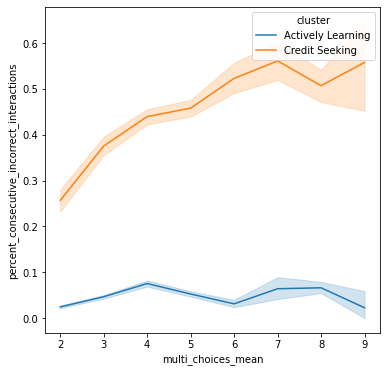

In [ ]:
Y = "u" 
Y = "percent_consecutive_incorrect_interactions" 
X = "multi_choices_mean"
# res = stats.linregress(sessions_attributes_fine_grained_multi[X], sessions_attributes_fine_grained_multi[Y])
# rvalue, pvalue = stats.pearsonr(x=sessions_attributes_fine_grained_multi[X], y=sessions_attributes_fine_grained_multi[Y])
# print(f"R: {res.rvalue}")
# print("P-value", pvalue)
fig, axs = plt.subplots(figsize=(6,6))

# gfg = sns.histplot(data=sessions_attributes_fine_grained_multi, x=X,hue='u', multiple="dodge",stat="percent", shrink=.8,)# bins=30)
gfg = sns.lineplot(data=sessions_attributes_fine_grained_multi, x=X, y=Y , hue='cluster')# bins=30)
# gfg = sns.lineplot(x=sessions_attributes_fine_grained_multi[X], y=res.intercept + res.slope * sessions_attributes_fine_grained_multi[X])

gfg.set(
    # xlabel="Percentage of credit seeking sessions per student",
    # ylabel="Final score",
)
# plt.legend(loc='upper right',  frameon=True,  shadow=True, title='r = -0.269\np-value = 0.002')

plt.show()
# fig.savefig("Multi-Correlation.pdf", facecolor="white",dpi=500)



In [ ]:
sessions_attributes_fine_grained_multi[sessions_attributes_fine_grained_multi["multi_choices_mean"]==1][['curr_frameset_name','n_incorrect_attempts_multi',
       'n_correct_attempts_multi', 'questions_incorrect_multi',
       'questions_correct_multi', 'choices_multi', 'solutions_multi',
       'n_interactions', 'cluster', 'u', 'n_multi',]]

,curr_frameset_name,n_incorrect_attempts_multi,n_correct_attempts_multi,questions_incorrect_multi,questions_correct_multi,choices_multi,solutions_multi,n_interactions,cluster,u,n_multi
36,ChomskyNormalFormFF,4,11,"{0, 3, 5, 7}","{0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11}","[3, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2]","[7, 3, 3, 3, 3, 3, 3, 1, 1, 1, 3]",16,Normal,0.035129,22
57,ChomskyNormalFormFF,1,11,{2},"{0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11}","[3, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2]","[7, 3, 3, 3, 3, 3, 3, 1, 1, 1, 3]",13,Normal,0.049238,22
91,ChomskyNormalFormFF,3,12,"{2, 11, 4}","{0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11}","[3, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2]","[7, 3, 3, 3, 3, 3, 3, 1, 1, 1, 3]",17,Normal,0.025785,24
129,ChomskyNormalFormFF,10,5,{6},"{6, 7, 8, 10, 11}","[2, 1, 1, 1, 2]","[3, 1, 1, 1, 3]",16,Credit Seeking,0.988122,10
150,ChomskyNormalFormFF,0,11,{},"{0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11}","[3, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2]","[7, 3, 3, 3, 3, 3, 3, 1, 1, 1, 3]",12,Normal,0.091837,22
181,ChomskyNormalFormFF,4,11,"{11, 3, 4, 5}","{0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11}","[3, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2]","[7, 3, 3, 3, 3, 3, 3, 1, 1, 1, 3]",16,Normal,0.045145,22
198,ChomskyNormalFormFF,0,11,{},"{0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11}","[3, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2]","[7, 3, 3, 3, 3, 3, 3, 1, 1, 1, 3]",13,Normal,0.049955,22
260,ChomskyNormalFormFF,0,6,{},"{6, 7, 8, 10, 11}","[2, 1, 1, 1, 2]","[3, 1, 1, 1, 3]",7,Normal,0.142739,12
336,ChomskyNormalFormFF,5,11,"{0, 11, 3, 4}","{0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11}","[3, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2]","[7, 3, 3, 3, 3, 3, 3, 1, 1, 1, 3]",17,Normal,0.093601,22
380,ChomskyNormalFormFF,2,11,"{2, 5}","{0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11}","[3, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2]","[7, 3, 3, 3, 3, 3, 3, 1, 1, 1, 3]",14,Normal,0.021059,22


In [ ]:
sessions_attributes_fine_grained_multi.columns

Index(['user_id', 'session_number', 'curr_frameset_name',
       'Percentage_incorrects', 'Percentage_corrects',
       'percent_consecutive_incorrect_interactions',
       'percent_consecutive_correct_interactions',
       'time_spent_incorrect_multi', 'n_incorrect_attempts_multi',
       'n_correct_attempts_multi', 'questions_incorrect_multi',
       'questions_correct_multi', 'choices_multi', 'solutions_multi',
       'n_interactions', 'time_spent_multi', 'cluster', 'u', 'n_multi',
       'multi_choices_median', 'multi_choices_mean', 'multi_solutions_median',
       'multi_solutions_mean', 'time_spent_incorrect_multi_sum',
       'time_spent_multi_sum', 'time_spent_multi_avg', 'multi_choices_sum',
       'multi_choices_mode', 'multi_choices_max', 'n_multi_questions'],
      dtype='object')

In [ ]:
sessions_attributes_fine_grained_multi['cluster']= sessions_attributes_fine_grained_multi['cluster'].replace('Normal', 'Actively Learning')
# sessions_attributes_fine_grained_multi= sessions_attributes_fine_grained_multi['cluster'].replace('Actively Learning', 'Normal')

C:\Users\Yusuf\AppData\Local\Temp\ipykernel_27000\3095353866.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sessions_attributes_fine_grained_multi['cluster']= sessions_attributes_fine_grained_multi['cluster'].replace('Normal', 'Actively Learning')


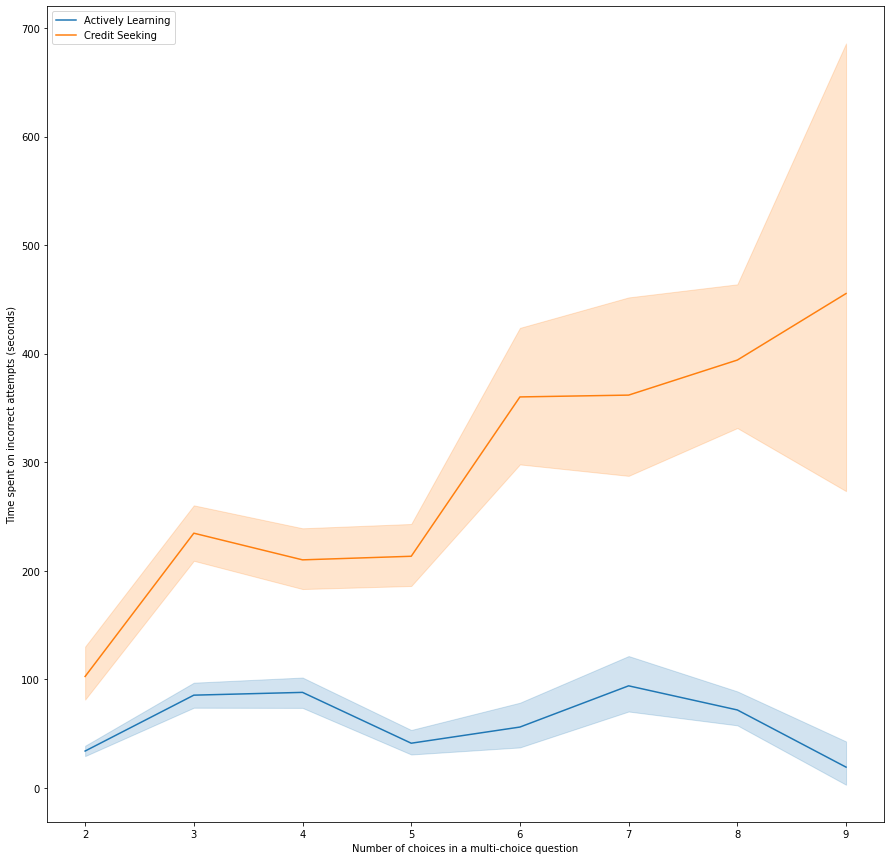

In [467]:
Y = "time_spent_incorrect_multi_sum" 
X = "multi_choices_median"
# res = stats.linregress(sessions_attributes_fine_grained_multi[X], sessions_attributes_fine_grained_multi[Y])
# rvalue, pvalue = stats.pearsonr(x=sessions_attributes_fine_grained_multi[X], y=sessions_attributes_fine_grained_multi[Y])
# print(f"R: {res.rvalue}")
# print("P-value", pvalue)
fig, axs = plt.subplots(figsize=(15,15))

# gfg = sns.histplot(data=sessions_attributes_fine_grained_multi, x=X,hue='u', multiple="dodge",stat="percent", shrink=.8,)# bins=30)
gfg = sns.lineplot(data=sessions_attributes_fine_grained_multi, x=X, y=Y , hue='cluster',markers=True,dashes=False)# bins=30)
# gfg = sns.lineplot(x=sessions_attributes_fine_grained_multi[X], y=res.intercept + res.slope * sessions_attributes_fine_grained_multi[X])

gfg.set(
    xlabel="Number of choices in a multi-choice question",
    ylabel="Time spent on incorrect attempts (seconds)"
)
# plt.legend(loc='upper right',  frameon=True,  shadow=True, title='r = -0.269\np-value = 0.002')

plt.show()
# fig.savefig("multi-choice-median-time-incorrect.pdf", facecolor="white",dpi=500)

# It means whether there are multiple number of choices or not, we may classifiy it as credit seeking or not

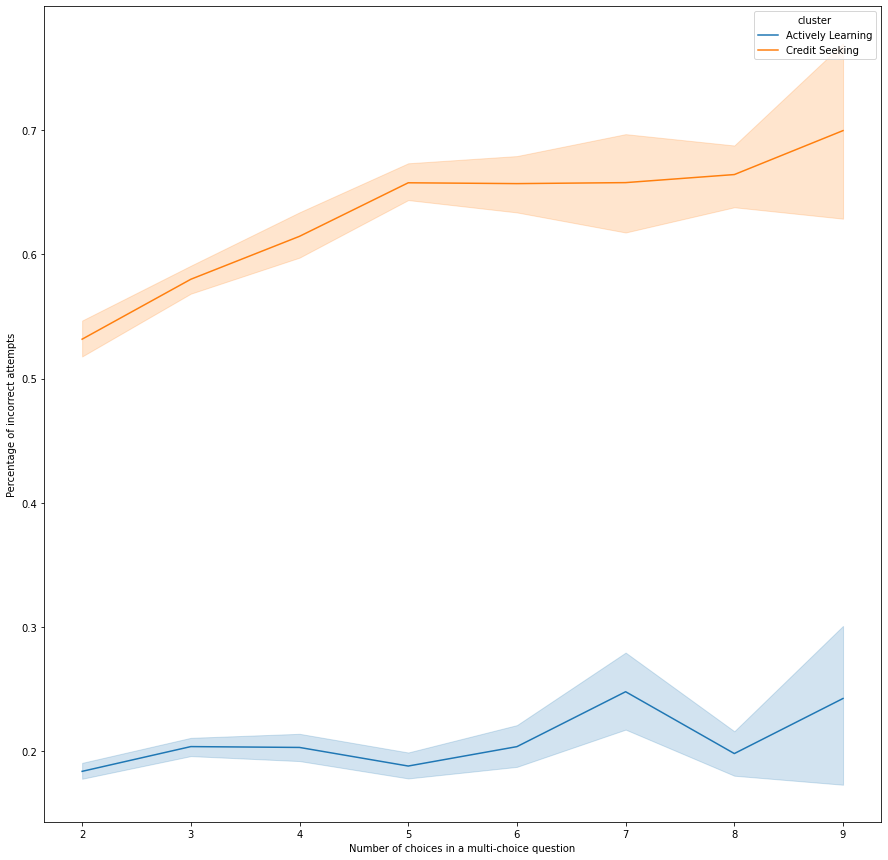

In [ ]:
Y = "u" 
Y = "Percentage_incorrects" 
X = "multi_choices_median"
# res = stats.linregress(sessions_attributes_fine_grained_multi[X], sessions_attributes_fine_grained_multi[Y])
# rvalue, pvalue = stats.pearsonr(x=sessions_attributes_fine_grained_multi[X], y=sessions_attributes_fine_grained_multi[Y])
# print(f"R: {res.rvalue}")
# print("P-value", pvalue)
fig, axs = plt.subplots(figsize=(6,6))

# gfg = sns.histplot(data=sessions_attributes_fine_grained_multi, x=X,hue='u', multiple="dodge",stat="percent", shrink=.8,)# bins=30)
gfg = sns.lineplot(data=sessions_attributes_fine_grained_multi, x=X, y=Y , hue='cluster')# bins=30)
# gfg = sns.lineplot(x=sessions_attributes_fine_grained_multi[X], y=res.intercept + res.slope * sessions_attributes_fine_grained_multi[X])

gfg.set(
    xlabel="Number of choices in a multi-choice question",
    # ylabel="Number of incorrect Attempts",
)
# plt.legend(loc='upper right',  frameon=True,  shadow=True, title='r = -0.269\np-value = 0.002')

plt.show()
# fig.savefig("Multi-Correlation.pdf"time-incorrect.pdf, facecolor="white",dpi=500)

# It means whether there are multiple number of choices or not, we may classifiy it as credit seeking or not